# Goal

This notebook checks model performance on a test set.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# DATALOADER PARAMS
bs          = 20
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
iso       = 3
maxs      = [87, 90, 90]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct, test_pct = .60, .20, .20

In [2]:
# CHECK HARDWARE 

import os
import torch

gpu_count = torch.cuda.device_count()
cpu_count = os.cpu_count()
print("#GPU = {0:d}, #CPU = {1:d}".format(gpu_count, cpu_count))

#GPU = 0, #CPU = 40


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Paths

In [3]:
# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, test.txt, CPTAC-GBM, ABIDE-ABIDE-top.txt, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [4]:
# imports
from transforms import AddChannel, Iso, PadSz

# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# regex
from re import search

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.distributed import *

# PyTorch
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils import *
from models import obelisk_visceral, obeliskhybrid_visceral

# 3D extension to FastAI
# from faimed3d.all import *

# Helper functions
from helpers.preprocess import get_data_dict, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers.viz import viz_axis

# Data

In [5]:
model_fns = os.listdir(model_src)
print(model_fns)

['iso_3mm_pad_87_90_90_bs_20_test_sz_67_epochs_30_time_Thu Jun 24 14:21:03 2021.pth', 'iso_3mm_pad_87_90_90_bs_20_test_sz_67_epochs_30_time_Thu Jun 24 14:21:03 2021_test_items.pkl']


In [6]:
model_fn = "iso_3mm_pad_87_90_90_bs_20_test_sz_67_epochs_30_time_Thu Jun 24 14:21:03 2021.pth"
test_fn  = model_fn[:-4] + "_test_items.pkl"

# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    ints = fn[start+len(prefix):end].split("_")
    if len(ints) == 1: return int(ints[0])
    return [int(x) for x in ints]

iso_sz  = get_param(model_fn, "iso_", "mm")
maxs    = get_param(model_fn, "pad_", "_bs")
bs      = get_param(model_fn, "bs_", "_test")
nepochs = get_param(model_fn, "epochs_", "_time")

# get test items
with open(f"{model_src}/{test_fn}", "rb") as input_file:
    test_items = pickle.load(input_file)
    
# get all items
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict(f"{label_src}/{folder}"))
items = list(data.values())

# print
print(f"Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Num test items: {len(test_items)}")
print(f"Num items: {len(items)}")

Iso: 3. PadResize to: [87, 90, 90]. bs = 20. nepochs = 30.
Num test items: 67
Num items: 335


In [7]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

# Dataloaders

In [66]:
# time it
start = time.time()

# tfms
tfms = [Iso(3), PadSz(maxs)]

# tls
tls = TfmdLists(test_items, tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(test_items)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Elapsed time: 0.08998894691467285 s for 67 items
<class 'tuple'> torch.Size([20, 1, 87, 90, 90]) torch.Size([20, 1, 87, 90, 90])
3 0


# Metric

Linear combination of Dice and Cross Entropy

In [144]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

# Learner

In [68]:
import gc
gc.collect()

9

In [69]:
full_res = maxs

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= loss, \
                metrics = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [82]:
# all predictions, 36
# predictions, loss = learn.get_preds(ds_idx=0)

# Viz

In [12]:
def bbox_union(bbox1, bbox2):
    l1 = [min(bbox1[i], bbox2[i]) for i in (0, 2, 4)]
    l2 = [max(bbox1[i], bbox2[i]) for i in (1, 3, 5)]    
    return [val for pair in zip(l1, l2) for val in pair]

In [14]:
# Viz

def viz_bbox(idx):
    mr, seg = learn.dls.train_ds[idx] 
    pred = learn.predict(test_items[idx])[0]
    
    # dice (add B dimension)
    dice = dice_score(pred.unsqueeze(0), seg.unsqueeze(0).unsqueeze(0))
    print(f"Dice: {dice:0.4f}")
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(mr)
    
    # union bbox
    bbox = bbox_union(gt_bbox, pred_bbox)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
    print("GT: "); print_bbox(*gt_bbox)
    print("Union: "); print_bbox(*bbox)
          
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
            bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
            slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
            bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
            slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


Dice: 0.8014
Pred: 
Bbox coords: (38, 42, 31) to (51, 55, 41). Size: 13, 13, 10.
Bounding box coord: from location (42, 31) of slice 38 to location (55, 41) of slice 51.
GT: 
Bbox coords: (20, 4, 19) to (68, 77, 82). Size: 48, 73, 63.
Bounding box coord: from location (4, 19) of slice 20 to location (77, 82) of slice 68.
Union: 
Bbox coords: (20, 4, 19) to (68, 77, 82). Size: 48, 73, 63.
Bounding box coord: from location (4, 19) of slice 20 to location (77, 82) of slice 68.


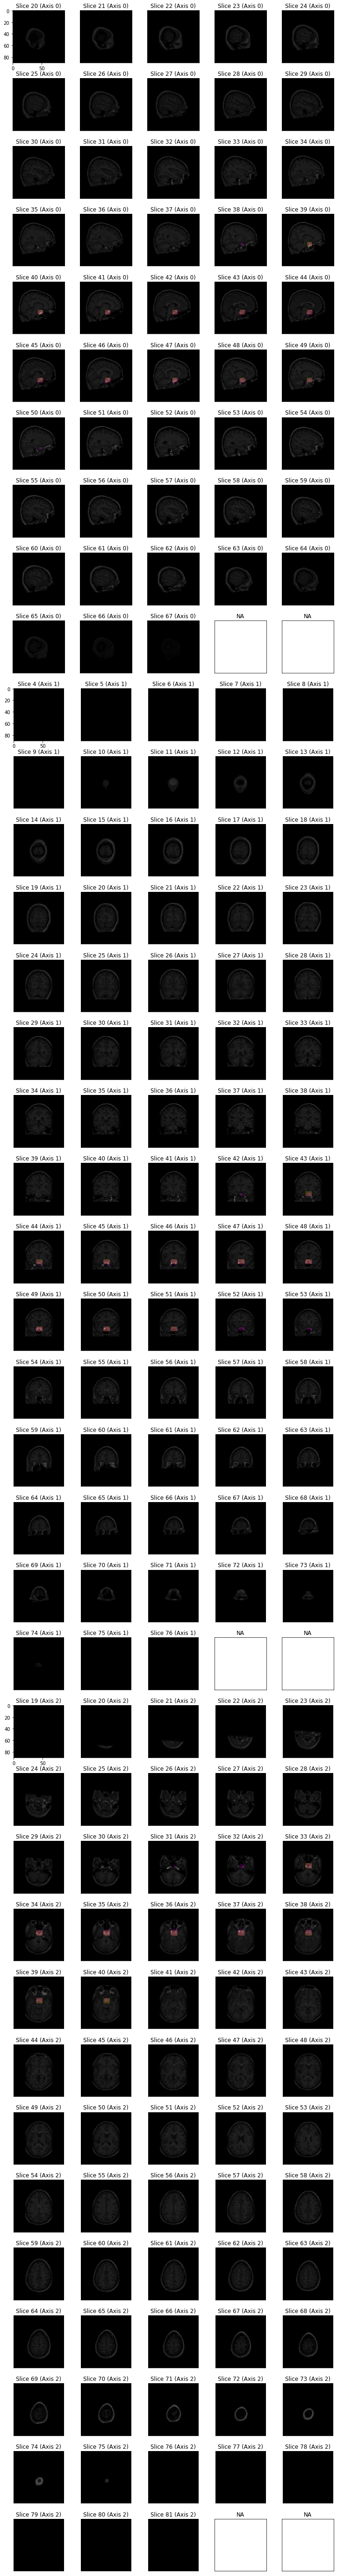

In [15]:
viz_bbox(0)

In [16]:
# 30 sec for 67 test items (2 CPU workers)
learn.validate(ds_idx=0)

(#2) [0.3425891101360321,0.7931706309318542]

# Predict unlabelled

In [13]:
ds = "ABIDE"
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

# load ABIDE files
with open(f"{deepPit_src}/saved_metadata/{ds}.txt", "rb") as input_file:
    ABIDE_fns = pickle.load(input_file)
    
# change prefix path
def change_src(overlap, s, new_src):
    return new_src + s[s.index(overlap) + len(overlap):]

ABIDE_fns = [change_src("PitMRdata", s, data_src) for s in ABIDE_fns]

# ABIDE ABIDE
ABIDE_ABIDE_fns = [fn for fn in ABIDE_fns if fn.startswith(f"{data_src}/ABIDE/ABIDE")]
print(f"ABIDE: {len(ABIDE_fns)} vs {len(ABIDE_ABIDE_fns)} files for ABIDE/ABIDE.")

# Get unlabelled files
def get_folder_name(s): 
    return re.search('\/([0-9]{5})\/', s).group(1)

ABIDE_folders = [get_folder_name(s) for s in ABIDE_ABIDE_fns]
labelled_folders = [child for folder in os.listdir(label_src) for child in os.listdir(f"{label_src}/{folder}")]
unlabelled_fns = [fn for fn in ABIDE_ABIDE_fns if get_folder_name(fn) not in labelled_folders]

# filter to exclude Matched_bandwidth_hires?
print(*unlabelled_fns[0:10], sep="\n")
print(os.listdir(unlabelled_fns[0])), print(os.listdir(unlabelled_fns[1]))

# unlabelled .nii files
unlabelled_items = [f"{fn}/{os.listdir(fn)[0]}" for fn in unlabelled_fns if "MP-RAGE" in fn]
print(len(unlabelled_items))

#unlabelled_folders = [folder for folder in ABIDE_folders if folder not in labelled_folders]
#print(f"Unlabelled_folders: {len(unlabelled_folders)}")

Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE
ABIDE: 1160 vs 1157 files for ABIDE/ABIDE.
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162786
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/MP-RAGE/2000-01-01_00_00_00.0/S164617
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51253/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162787
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51253/MP-RAGE/2000-01-01_00_00_00.0/S164659
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51233/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162788
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51249/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162789
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51249/MP-RAGE/2000-01-01_00_00_00.0/S164442
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51210/M

In [100]:
class IsoTestSet(Transform):
    
    def __init__(self, new_sp = 3):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path = x
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
        im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
       
        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        while im.ndim < 5: 
            im = im.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze()
    
class Unsqueeze(Transform):
    def encodes(self, x):
        return x.unsqueeze(1) #.unsqueeze(0)

In [137]:
print(test_items[0]) 
print(unlabelled_items[0])

('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/MP-RAGE/2000-01-01_00_00_00.0/S164885/ABIDE_50406_MRI_MP-RAGE_br_raw_20120830190936945_S164885_I328895.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/seg.pt')
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/MP-RAGE/2000-01-01_00_00_00.0/S164617/ABIDE_51236_MRI_MP-RAGE_br_raw_20120830172549161_S164617_I328625.nii


In [142]:
# test DLs (no labelled segm obj)

unlabelled_items_subset = unlabelled_items[0:30]
unlabelled_items_subset = [(a,a) for a in unlabelled_items_subset]

unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
unlbl_tls = TfmdLists(unlabelled_items_subset, unlbl_tfms)
unlbl_dls = unlbl_tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# e

# unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
# unlbl_dl = TfmdDL(Datasets(unlabelled_items_subset), \
#                   after_item=unlbl_tfms, \
#                   after_batch=AddChannel(), \
#                   bs=bs, num_workers=num_workers)

# #dl = TfmdDL(Datasets(torch.arange(50), tfms = [L(), [_Add1()]]))
# unlbl_dls = DataLoaders(unlbl_dl, unlbl_dl)

# tls       = TfmdLists(unlabelled_items, test_tfms)
# test_dls = tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# test get one batch
b = unlbl_dls.one_batch()
print(type(b), len(b), b[0].shape, b[1].shape)
print(len(unlbl_dls.train_ds), len(unlbl_dls.valid_ds))

<class 'tuple'> 2 torch.Size([20, 1, 87, 90, 90]) torch.Size([20, 1, 87, 90, 90])
30 0


In [145]:
# all predictions, 36

full_res = maxs

unlbl_learn = Learner(dls=unlbl_dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= loss, \
                metrics = dice_score)

# load model fname w/o .pth extension
unlbl_learn.load(f"{model_src}/{model_fn[:-4]}")

In [147]:
learn.predict??

In [146]:
is_cat,_,probs = unlbl_learn.predict(unlabelled_items_subset[0])

RuntimeError: expected scalar type Long but found Float

In [116]:
learn.predict()

In [153]:
unlbl_learn.get_preds??

In [155]:
unlbl_predictions = unlbl_learn.get_preds(dl=unlbl_dl)[0]
print(unlbl_predictions.shape)

In [165]:
# Viz

def viz_bbox_unlbl(idx):
    mr = unlbl_learn.dls.train_ds[idx][0] 
    pred = unlbl_predictions[idx]
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, pred_mk = np.array(mr), np.array(pred_mk)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
 
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = pred_mk,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*pred_bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = pred_mk,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b = lrange(*pred_bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = pred_mk,     color1_c = "yellow",  alpha1_c=0.3, \
            slices_c = lrange(*pred_bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


Pred: 
Bbox coords: (38, 47, 44) to (52, 61, 52). Size: 14, 14, 8.
Bounding box coord: from location (47, 44) of slice 38 to location (61, 52) of slice 52.


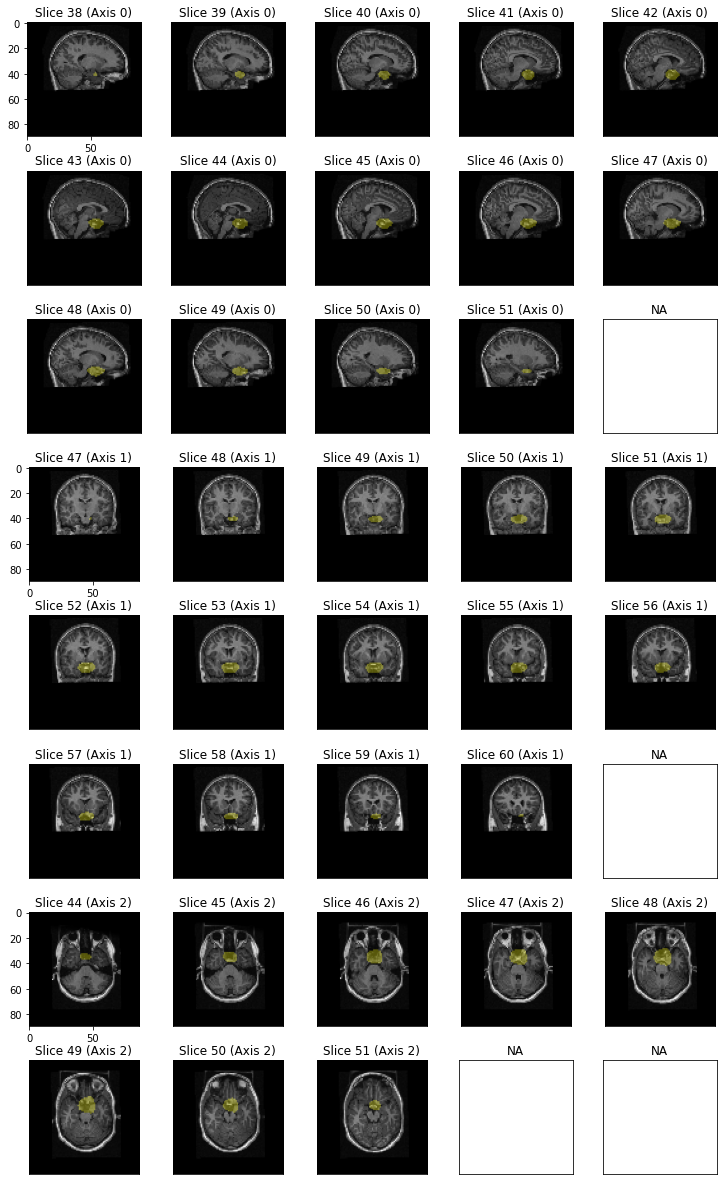

In [166]:
viz_bbox_unlbl(0)